# Assignment 2 For Clustering: Sessa Empirical Estimator

Abangan, Jaerian Peter <br>
Berbo, Chris Derek <br>
BSCS - 3

<hr>

## Converting the R codes into Python Codes:

### Using the Sessa Empircal Estimator:

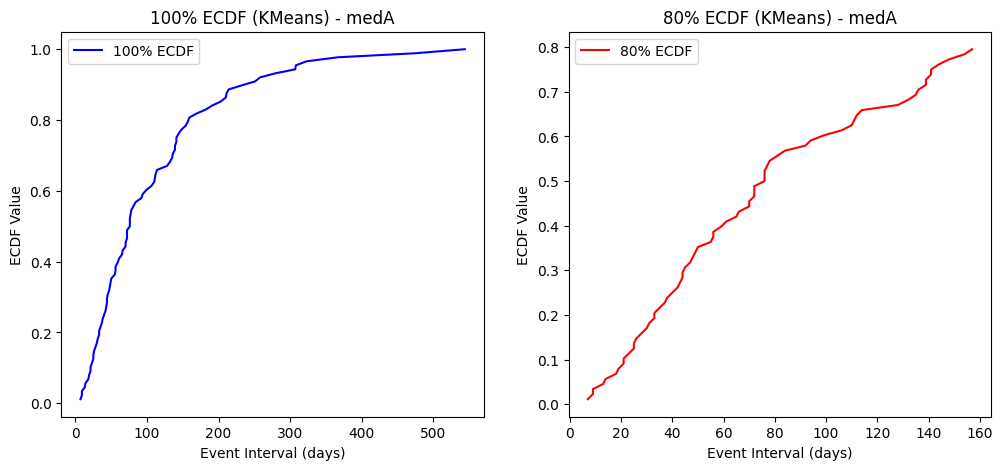

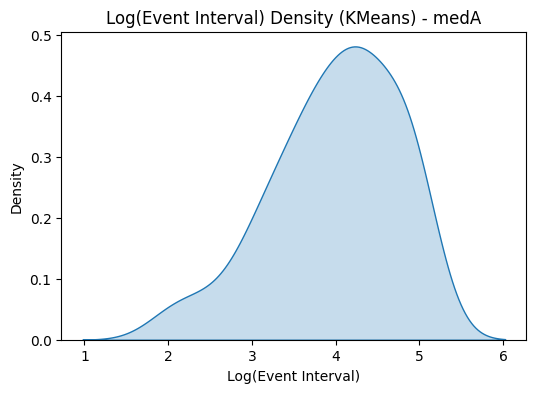

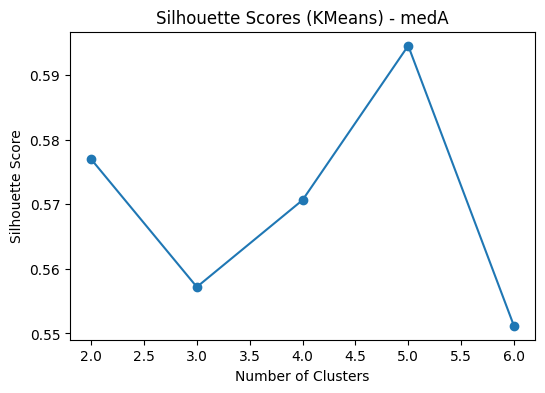

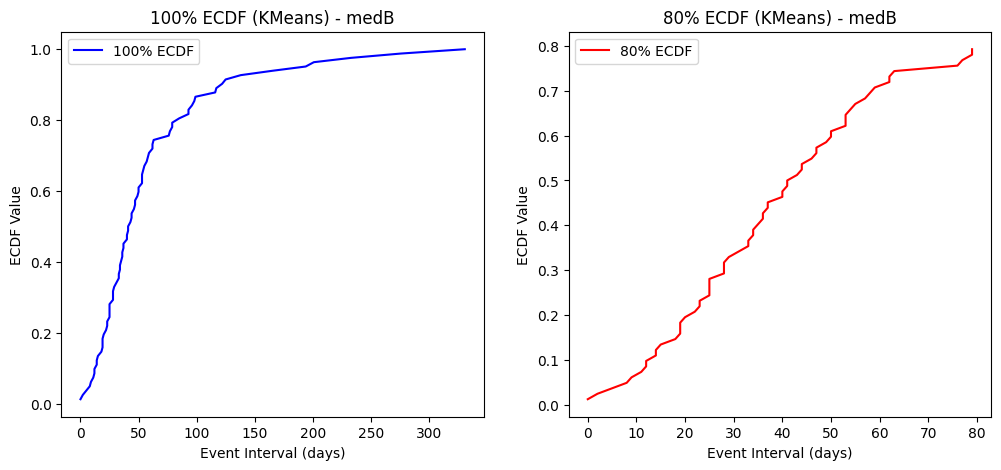

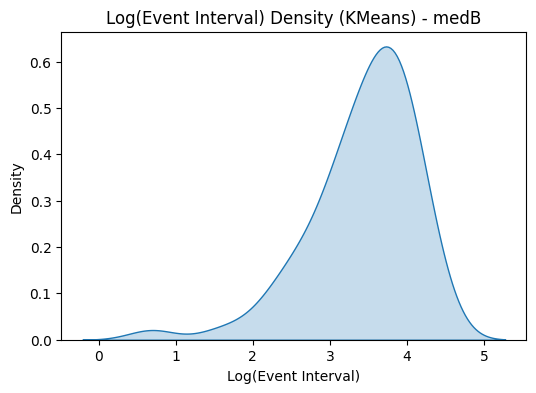

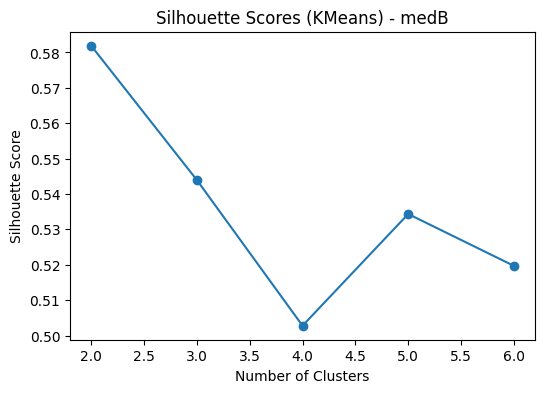

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load dataset
data = pd.read_csv("Data/med_events.csv")
data.rename(columns={'PATIENT_ID': 'pnr', 'DATE': 'eksd', 'CATEGORY': 'ATC'}, inplace=True)
data['eksd'] = pd.to_datetime(data['eksd'], format='%m/%d/%Y', errors='coerce')

def ecdf(values):
    x = np.sort(values)
    y = np.arange(1, len(values) + 1) / len(values)
    return x, y

def plot_density(log_intervals, label, method):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(log_intervals.flatten(), fill=True)
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title(f"Log(Event Interval) Density ({method}) - {label}")
    plt.show()

def plot_ecdf(df_ecdf, df_ecdf_80, label, method):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(df_ecdf['x'], df_ecdf['y'], label="100% ECDF", color="blue")
    axes[0].set_xlabel("Event Interval (days)")
    axes[0].set_ylabel("ECDF Value")
    axes[0].set_title(f"100% ECDF ({method}) - {label}")
    axes[0].legend()
    
    if not df_ecdf_80.empty:
        axes[1].plot(df_ecdf_80['x'], df_ecdf_80['y'], label="80% ECDF", color="red")
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12, color='red')
    
    axes[1].set_xlabel("Event Interval (days)")
    axes[1].set_ylabel("ECDF Value")
    axes[1].set_title(f"80% ECDF ({method}) - {label}")
    
    plt.show()

def plot_silhouette(log_intervals, label, method):
    silhouette_scores = []
    for k in range(2, 7):
        try:
            labels = KMeans(n_clusters=k, random_state=1234).fit_predict(log_intervals)
            score = silhouette_score(log_intervals, labels)
            silhouette_scores.append((k, score))
        except:
            continue
    
    if silhouette_scores:
        plt.figure(figsize=(6, 4))
        plt.plot(*zip(*silhouette_scores), marker="o")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Score")
        plt.title(f"Silhouette Scores ({method}) - {label}")
        plt.show()

def see_kmeans(atc_code, data, label, random_state=1234):
    df = data[data['ATC'] == atc_code].copy()
    df = df.sort_values(['pnr', 'eksd']).reset_index(drop=True)
    df['prev_eksd'] = df.groupby('pnr')['eksd'].shift(1)
    df.dropna(subset=['prev_eksd'], inplace=True)
    df_sampled = df.groupby('pnr', group_keys=False).sample(n=1, random_state=random_state)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days.astype(float)
    
    xvals, yvals = ecdf(df_sampled['event_interval'].values)
    df_ecdf = pd.DataFrame({'x': xvals, 'y': yvals})
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8].copy()
    
    plot_ecdf(df_ecdf, df_ecdf_80, label, "KMeans")
    
    if df_ecdf_80.empty:
        print(f"No valid 80% ECDF data for {label}")
        return df
    
    max_x = df_ecdf_80['x'].max()
    df_filtered = df_sampled[df_sampled['event_interval'] <= max_x]
    log_intervals = np.log(df_filtered['event_interval'].replace(0, np.nan)).dropna().values.reshape(-1, 1)
    plot_density(log_intervals, label, "KMeans")
    plot_silhouette(log_intervals, label, "KMeans")
    return df

if __name__ == "__main__":
    see_kmeans('medA', data, label='medA')
    see_kmeans('medB', data, label='medB')


### Using different Clustering Algorithm (DBSCAN)

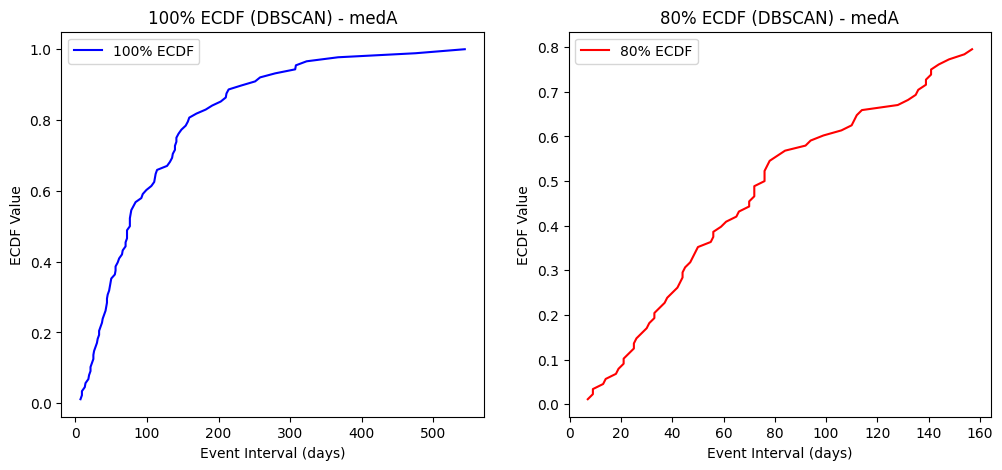

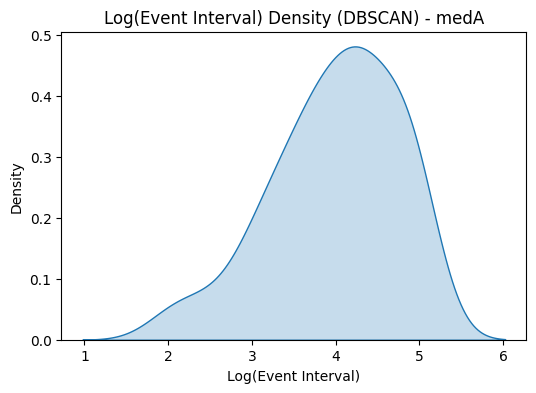

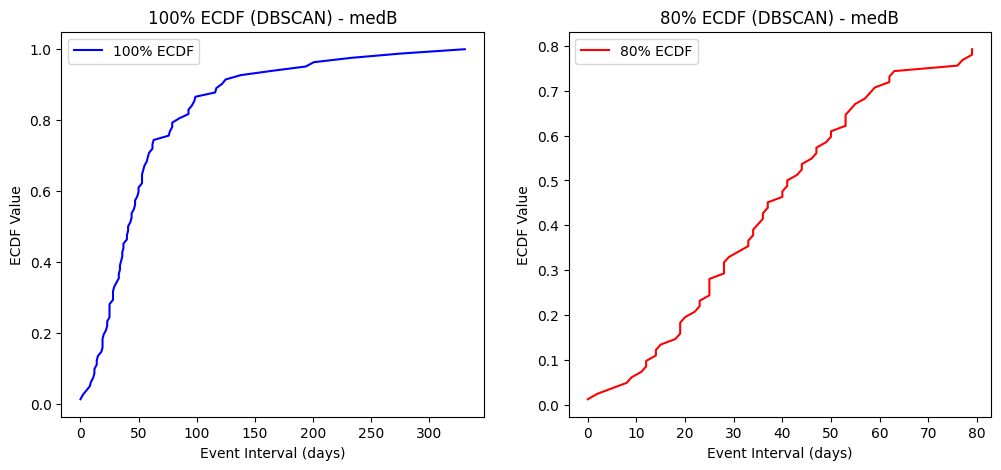

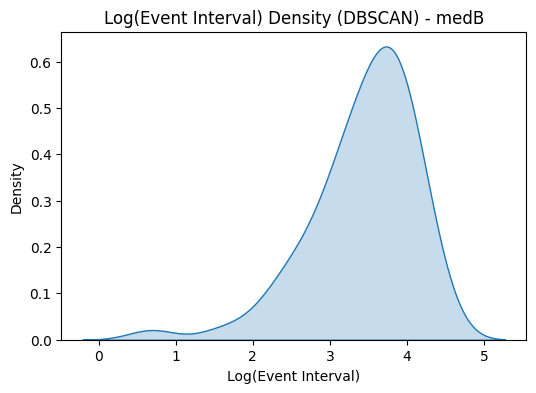

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("Data/med_events.csv")
data.rename(columns={'PATIENT_ID': 'pnr', 'DATE': 'eksd', 'CATEGORY': 'ATC'}, inplace=True)
data['eksd'] = pd.to_datetime(data['eksd'], format='%m/%d/%Y', errors='coerce')

def ecdf(values):
    x = np.sort(values)
    y = np.arange(1, len(values) + 1) / len(values)
    return x, y

def plot_density(log_intervals, label, method):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(log_intervals.flatten(), fill=True)
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.title(f"Log(Event Interval) Density ({method}) - {label}")
    plt.show()

def plot_ecdf(df_ecdf, df_ecdf_80, label, method):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(df_ecdf['x'], df_ecdf['y'], label="100% ECDF", color="blue")
    axes[0].set_xlabel("Event Interval (days)")
    axes[0].set_ylabel("ECDF Value")
    axes[0].set_title(f"100% ECDF ({method}) - {label}")
    axes[0].legend()
    
    if not df_ecdf_80.empty:
        axes[1].plot(df_ecdf_80['x'], df_ecdf_80['y'], label="80% ECDF", color="red")
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12, color='red')
    
    axes[1].set_xlabel("Event Interval (days)")
    axes[1].set_ylabel("ECDF Value")
    axes[1].set_title(f"80% ECDF ({method}) - {label}")
    
    plt.show()

def see_dbscan(atc_code, data, label, random_state=1234):
    df = data[data['ATC'] == atc_code].copy()
    df = df.sort_values(['pnr', 'eksd']).reset_index(drop=True)
    df['prev_eksd'] = df.groupby('pnr')['eksd'].shift(1)
    df.dropna(subset=['prev_eksd'], inplace=True)
    df_sampled = df.groupby('pnr', group_keys=False).sample(n=1, random_state=random_state)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days.astype(float)
    
    xvals, yvals = ecdf(df_sampled['event_interval'].values)
    df_ecdf = pd.DataFrame({'x': xvals, 'y': yvals})
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8].copy()
    
    plot_ecdf(df_ecdf, df_ecdf_80, label, "DBSCAN")
    
    if df_ecdf_80.empty:
        print(f"No valid 80% ECDF data for {label}")
        return df
    
    max_x = df_ecdf_80['x'].max()
    df_filtered = df_sampled[df_sampled['event_interval'] <= max_x]
    log_intervals = np.log(df_filtered['event_interval'].replace(0, np.nan)).dropna().values.reshape(-1, 1)
    plot_density(log_intervals, label, "DBSCAN")
    return df

if __name__ == "__main__":
    see_dbscan('medA', data, label='medA')
    see_dbscan('medB', data, label='medB')
